In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#from jupyterthemes import jtplot
#jtplot.style()

#from wrangle import wrangle_zillow, split_zillow
#from scale_and_featureeng import select_kbest, rfe, scale_data

#import explore

plt.rcParams['figure.figsize'] = (8,4)

In [3]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import os

def new_zillow_data():
    '''
    This function reads the zillow data from the Codeup db into a df,
    write it to a csv file, and returns the df.
    '''
    # Create SQL query.
    sql_query = ''' select parcelid, 
                        bathroomcnt, 
                        bedroomcnt,
                        calculatedfinishedsquarefeet,
                        fips,
                        latitude,
                        longitude,
                        lotsizesquarefeet,
                        regionidzip,
                        yearbuilt,
                        taxvaluedollarcnt,
                        taxamount,
                        transactiondate 
      from properties_2017
      join predictions_2017 using(parcelid)
      where transactiondate between "2017-05-01" and "2017-08-31"
      AND (unitcnt = 1 OR propertylandusetypeid IN (261, 279, 262, 263, 264, 266, 275));
                    '''
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_zillow_data(cached=False):
    '''
    This function reads in zillow data from Codeup database and writes data to
    a csv file if cached == False or if cached == True reads in telco df from
    a csv file, returns df.
    '''
    if cached == False or os.path.isfile('zillow.csv') == False:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow.csv')
        
    else:
        
        # If csv file exists or cached == True, read in data from csv.
        df = pd.read_csv('zillow.csv', index_col=1)
        
    return df

def clean_zillow(df):
    '''Takes in a df of zillow data and cleans the data by dropping null values, renaming columns, creating age column,
        and dealing with outliers using 1.5x IQR    
    
    return: df, a cleaned pandas dataframe'''
    
    df = df.set_index('parcelid')  

    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    df = df.dropna()
    df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet":    
                                    "square_feet","taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})
    
    df['age_in_years'] = 2021 - df.yearbuilt
    df['Bathrooms_cat'] = df.bathrooms.apply(lambda x: "4+" if x >= 4 else x)
    df['Bedrooms_cat'] = df.bathrooms.apply(lambda x: "4+" if x >= 4 else x)
    df['tax_rate'] = round(((df.taxes / df.tax_value) * 100), 2)
    df = df.drop(columns=['yearbuilt']) 
    
    q1 = df.tax_value.quantile(.25)
    q3 = df.tax_value.quantile(.75)
    iqr = q3 - q1
    multiplier = 1.5
    upper_bound = q3 + (multiplier * iqr)
    lower_bound = q1 - (multiplier * iqr)
    df = df[df.tax_value > lower_bound]
    df = df[df.tax_value < upper_bound]
    
    return df

def split_zillow(df, stratify_by=None):
    """
    train, validate, test split
    To stratify, send in a column name
    """
    
    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(df, test_size=.3, random_state=123)
    else:
        train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate[stratify_by])
    
    return train, validate, test

def wrangle_zillow(split=False):
    '''
    wrangle_zillow will read zillow.csv as a pandas dataframe,
    clean the data
    split the data
    return: train, validate, test sets of pandas dataframes from zilow if split = True
    '''
    df = clean_zillow(get_zillow_data())
    if split == True:
        return split_zillow(df)
    else:
        return df

In [4]:
import pandas as pd
import numpy as np

import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression

def select_kbest(X, y, k):
    f_selector = SelectKBest(f_regression, k)
    f_selector.fit(X, y)
    feature_mask = f_selector.get_support()

    f_feature = X.iloc[:,feature_mask].columns.tolist()
    return f_feature

def rfe(X,y,k):
    lm = LinearRegression()
    rfe = RFE(lm,k)
    rfe.fit(X, y)
    feature_mask_rfe = rfe.support_
    rfe_feature = X.iloc[:,feature_mask_rfe].columns.tolist()
    return rfe_feature

def scale_data(train,validate,test):
    '''Accepts train, validate, test data frames and applies min-max scaler
    return: train, validate, test scaled pandas dataframe'''
    
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    validate_scaled = scaler.transform(validate)
    test_scaled = scaler.transform(test)
    
    train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
    validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
    test_scaled = pd.DataFrame(test_scaled, columns=train.columns)
    
    return train_scaled, validate_scaled, test_scaled

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test


def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
        
def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)

def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


### Univariate

def explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = freq_table(train, cat_var)
    plt.figure(figsize=(4,4))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(10,4))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats
    
def freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table


#### Bivariate

def explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = run_chi2(train, cat_var, target)
    p = plot_cat_by_target(train, target, cat_var)
    
    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = plot_boxen(train, target, quant_var)
    swarm = plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")

## Bivariate Categorical

def run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(4,4))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p
    

## Bivariate Quant

def plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)


### Multivariate

def plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing survived. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()
    
def plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

In [8]:
df = pd.read_csv('train.csv')
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ClaimNumber                54000 non-null  object 
 1   DateTimeOfAccident         54000 non-null  object 
 2   DateReported               54000 non-null  object 
 3   Age                        54000 non-null  int64  
 4   Gender                     54000 non-null  object 
 5   MaritalStatus              53971 non-null  object 
 6   DependentChildren          54000 non-null  int64  
 7   DependentsOther            54000 non-null  int64  
 8   WeeklyWages                54000 non-null  float64
 9   PartTimeFullTime           54000 non-null  object 
 10  HoursWorkedPerWeek         54000 non-null  float64
 11  DaysWorkedPerWeek          54000 non-null  int64  
 12  ClaimDescription           54000 non-null  object 
 13  InitialIncurredCalimsCost  54000 non-null  int

In [10]:
df.describe()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04,5.400000e+04
mean,33.842370,0.119185,0.009944,416.364807,37.735084,4.905759,7.841146e+03,1.100337e+04
std,12.122165,0.517780,0.109348,248.638669,12.568704,0.552129,2.058408e+04,3.339099e+04
min,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.218868e+02
25%,23.000000,0.000000,0.000000,200.000000,38.000000,5.000000,7.000000e+02,9.263384e+02
50%,32.000000,0.000000,0.000000,392.200000,38.000000,5.000000,2.000000e+03,3.371242e+03
75%,43.000000,0.000000,0.000000,500.000000,40.000000,5.000000,9.500000e+03,8.197249e+03
max,81.000000,9.000000,5.000000,7497.000000,640.000000,7.000000,2.000000e+06,4.027136e+06


In [14]:


# splitting columns between categorical and quantitative for explore functions
cat_vars = ['Gender', 'MaritalStatus', 'PartTimeFullTime']

quant_vars = ['Age',                         
              'DependentChildren',              
              'DependentsOther',
              'WeeklyWages',              
              'HoursWorkedPerWeek',
              'InitialIncurredCalimsCost',
              'UltimateIncurredClaimCost'
              ]



In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd

#For Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

#For Applying Nlp On Claim Description Column
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


[nltk_data] Downloading package punkt to /home/ken/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/ken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [19]:
#Entire Dataset
df_all = pd.concat([train.assign(role="train"), test.assign(role="test")])

In [22]:
df_all.isnull().sum()/len(df_all)*100

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,role
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,train
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,train
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,train
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,train
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,train


In [25]:


df_all.isnull().sum()/len(df_all)*100


ClaimNumber                   0.000000
DateTimeOfAccident            0.000000
DateReported                  0.000000
Age                           0.000000
Gender                        0.000000
MaritalStatus                 0.052222
DependentChildren             0.000000
DependentsOther               0.000000
WeeklyWages                   0.000000
PartTimeFullTime              0.000000
HoursWorkedPerWeek            0.000000
DaysWorkedPerWeek             0.000000
ClaimDescription              0.000000
InitialIncurredCalimsCost     0.000000
UltimateIncurredClaimCost    40.000000
role                          0.000000
dtype: float64

In [26]:
df_all.groupby(df_all['MaritalStatus'])['UltimateIncurredClaimCost'].agg(['mean','median','count'])

,mean,median,count
MaritalStatus,,,
M,12024.933597,4166.460054,22516
S,9105.578095,2322.799731,26161
U,16067.822199,5851.980317,5294


In [27]:


df_all[df_all['MaritalStatus'].isnull()]['UltimateIncurredClaimCost'].mean()



5325.89606395862

In [28]:


#Replacing nan with S

df_all['MaritalStatus']=df_all['MaritalStatus'].fillna('S')



In [29]:


#Each Type Of Claim and its freq

df_all['ClaimDescription'].value_counts()



SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER                        468
SORTING ALUMINIUM BARS STRAIN SHOULDER NECK                        462
SLIPPED USING LATHE IN EYE CORNEA                                  453
LIFTING BACK STRAIN LOWER BACK STRAIN                              422
FELL DOWN STAIRS BACK SPRAIN                                       421
                                                                  ... 
REPETATIVE HEAVY USE SOFT TISSUE NECK                                1
HIT WITH HAMMER BRUISED LEFT FOREARM                                 1
SLIPPED METRES OF LADDER AND FELL LACERATION LEFT ELBOW INJURY       1
PICKED UP KG BAG AND DRUM CRUSH INJURY BRUISED RIGHT SHIN ELBOW      1
CAUGHT FINGER UNDER TRAY CRUSH INJURY LEFT LITTLE FINGER             1
Name: ClaimDescription, Length: 40933, dtype: int64

In [30]:


# Claim Cost varies wrt claim descr. 

df_all[df_all.role=='train'].groupby(['ClaimDescription'])['UltimateIncurredClaimCost'].median().sort_values(ascending=False)



ClaimDescription
SLIPPED ON WET FLOOR FRACTURED BASE OF HAND                   4.027136e+06
WHILST MASSAGING FELT PAIN SOFT TISSUE INJURY LEFT HAND       8.657706e+05
TABLE TIPPED OVER SOFT TISSUE INJURY RIGHT HAND               8.237063e+05
HANDLING BROCOLLI PAIN AND SWELLING LEFT KNEE SOFT TISSUE     5.257133e+05
STAPLED FINGER WITH KNIFE STRESS TRAUMA                       5.164342e+05
                                                                  ...     
METAL FOREIGN BODY LEFT EYE                                   1.423778e+02
HIT AGAINST WELDER MACHINE BRUISED ABRASION RIGHT EYE         1.412889e+02
PARTICLE FELL INTO EYE FOREIGN BODY IN LEFT SHOULDER          1.343203e+02
PARTICLE IN EYE WHILE GRINDING FOREIGN BODY RIGHT EYE AREA    1.314570e+02
GLASS INTO EYE FOREIGN BODY LEFT EYE                          1.245797e+02
Name: UltimateIncurredClaimCost, Length: 28114, dtype: float64

In [31]:


# Number Of words in each claim description

df_all['word_count']=df_all['ClaimDescription'].apply(lambda x:len(x))



In [32]:


#  word count statistics in each claim description

df_all['word_count'].describe()



count    90000.000000
mean        43.449811
std         10.206774
min          3.000000
25%         37.000000
50%         43.000000
75%         50.000000
max         94.000000
Name: word_count, dtype: float64

In [35]:
stops = stopwords.words('english')

def text_clean(claim):
    
    
    #Converting to Lower Case
    claim=claim.lower()
    
    #Getting List Of Words
    claim=claim.split()
    
    #Removing Stop Words(Words which do not add any information like =is,are,I etc)
    claim=[word for word in claim if word not in stops]
    
    #Stemming the word(words like playing ,played are replaced with play)
    porter_stemmer = PorterStemmer()
    claim=[porter_stemmer.stem(word) for word in claim]
    
    
    return claim


In [36]:
df_all['ClaimDescriptionClean']=df_all['ClaimDescription'].apply(lambda x:' '.join(text_clean(x)))


In [39]:
corpus = df_all['ClaimDescriptionClean']
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))


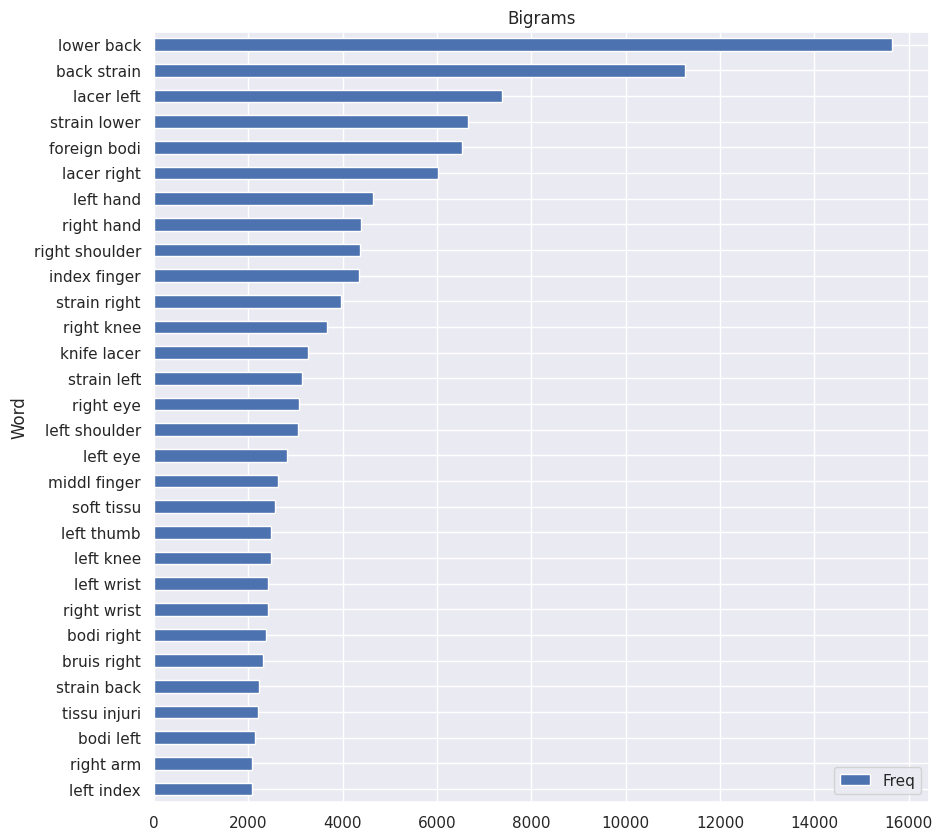

In [41]:
#Most common pairs of words that occur together in Claim Description

plt.figsize=((25,30))
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(kind="barh",figsize=(10,10))
plt.title('Bigrams')
                  
plt.show()


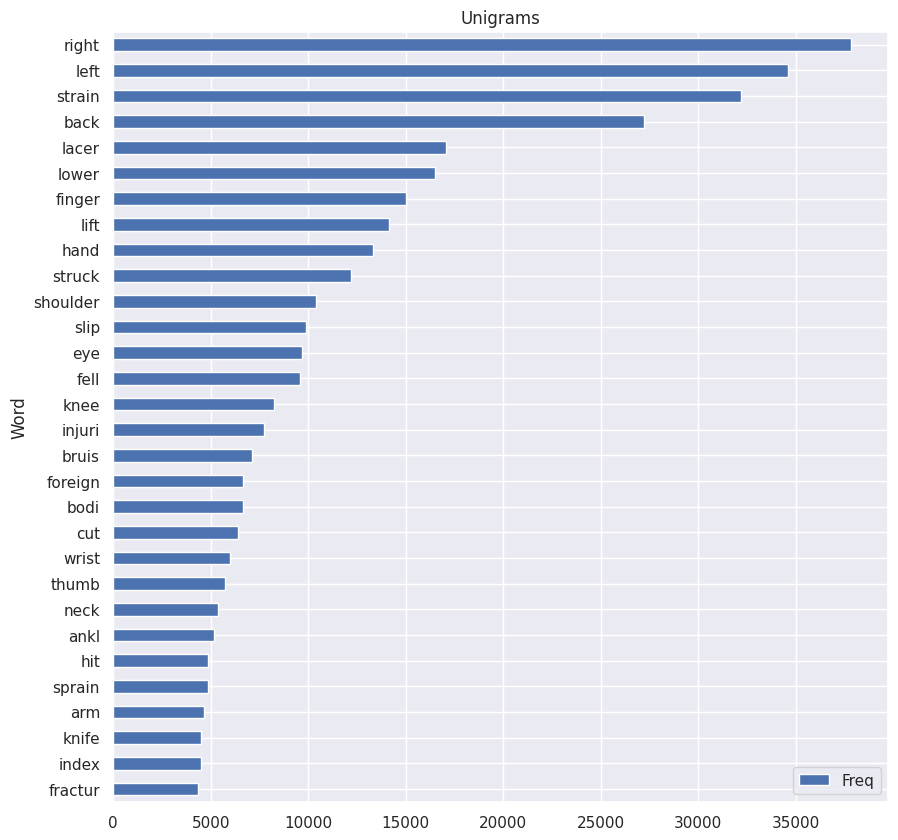

In [42]:
# single words that frequently occur in claim descr.

plt.figsize=((25,30))
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 1))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(kind="barh",figsize=(10,10))
plt.title('Unigrams')
                  
plt.show()

In [43]:
#Creating new features based on claim descr

cd_features=['foreign bodi','lacer','tissu injuri','strain','lower back','knee','wrist','eye','hand','fractur','sprain','knife','slip','finger','tendon','synov','conjunct']

for feature in cd_features:
    df_all['CD_'+'_'.join(feature.split())]=df_all['ClaimDescriptionClean'].apply(lambda x:1 if feature in x else 0)
    
#Creating Features based on Claim description col.   
cd_features=['CD_'+'_'.join(feature.split()) for feature in cd_features]


In [44]:
df_all.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,CD_eye,CD_hand,CD_fractur,CD_sprain,CD_knife,CD_slip,CD_finger,CD_tendon,CD_synov,CD_conjunct
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,...,0,0,0,0,0,0,0,0,0,0
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,...,0,0,1,0,0,0,0,0,0,0
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,...,0,0,0,0,0,0,0,0,0,0
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,...,0,0,0,0,0,0,0,0,0,0
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df_all[['DateTimeOfAccident', 'DateReported']].tail()

,DateTimeOfAccident,DateReported
35995,2005-03-14T18:00:00Z,2005-07-20T00:00:00Z
35996,1994-05-17T12:00:00Z,1994-05-31T00:00:00Z
35997,1991-07-18T09:00:00Z,1991-07-30T00:00:00Z
35998,2000-08-01T11:00:00Z,2000-09-05T00:00:00Z
35999,1996-11-27T08:00:00Z,1996-12-02T00:00:00Z


In [46]:
df_all['DateTimeOfAccident']=pd.to_datetime(df_all['DateTimeOfAccident'])
df_all['DateReported']=pd.to_datetime(df_all['DateReported'])

df_all['Rep_Acc_Diff']=df_all['DateReported']-df_all['DateTimeOfAccident']
df_all['Rep_Acc_Diff']=df_all['Rep_Acc_Diff'].apply(lambda x:str(x)[:2])
df_all['Rep_Acc_Diff']=df_all['Rep_Acc_Diff'].astype('int')

df_all['Accident_Month']=df_all['DateTimeOfAccident'].dt.month
df_all['Accident_Year']=df_all['DateTimeOfAccident'].dt.year
df_all['Accident_Day']=df_all['DateTimeOfAccident'].dt.day
df_all['Accident_Hour']=df_all['DateTimeOfAccident'].dt.hour
df_all['Accident_Time']=df_all['DateTimeOfAccident'].dt.time



df_all['Reported_Month']=df_all['DateReported'].dt.month
df_all['Reported_Year']=df_all['DateReported'].dt.year
df_all['Reported_Day']=df_all['DateReported'].dt.day


In [47]:


train=df_all[df_all.role=='train']



In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   ClaimNumber                54000 non-null  object             
 1   DateTimeOfAccident         54000 non-null  datetime64[ns, UTC]
 2   DateReported               54000 non-null  datetime64[ns, UTC]
 3   Age                        54000 non-null  int64              
 4   Gender                     54000 non-null  object             
 5   MaritalStatus              54000 non-null  object             
 6   DependentChildren          54000 non-null  int64              
 7   DependentsOther            54000 non-null  int64              
 8   WeeklyWages                54000 non-null  float64            
 9   PartTimeFullTime           54000 non-null  object             
 10  HoursWorkedPerWeek         54000 non-null  float64            
 11  Da

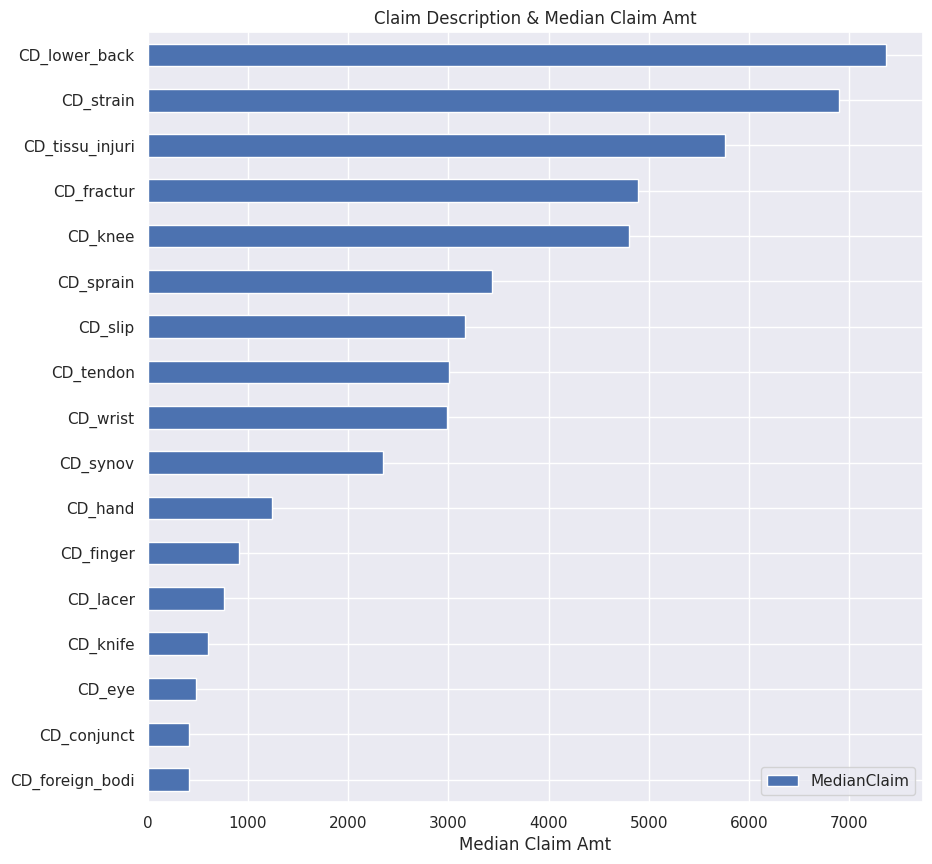

In [49]:
cd_feat_claim_median=pd.DataFrame({feature:train[train[feature]==1]['UltimateIncurredClaimCost'].median() for feature in cd_features},index=['MedianClaim']
).T.sort_values(by='MedianClaim')

cd_feat_claim_median.plot(kind='barh',figsize=(10,10))

plt.xlabel('Median Claim Amt')
plt.title('Claim Description & Median Claim Amt')
plt.show()


In [50]:


date_cols=[col for col in train.columns if col.split('_')[-1] in ['Month','Year','Day','Time']]



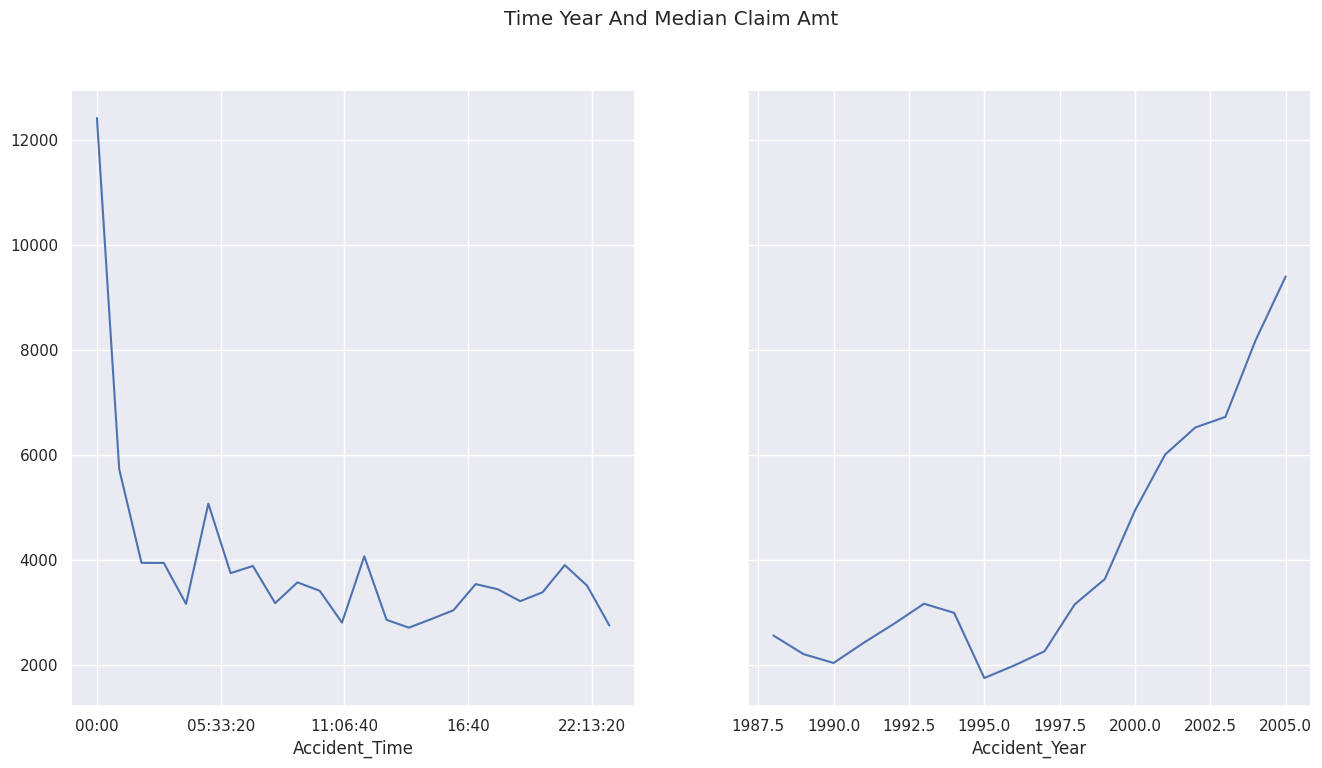

In [51]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
fig.suptitle('Time Year And Median Claim Amt')
plt.ylabel('Median Claim Amt')

train.groupby(train['Accident_Time'])['UltimateIncurredClaimCost'].median().plot(ax=ax[0])
train.groupby(train['Accident_Year'])['UltimateIncurredClaimCost'].median().plot(ax=ax[1])

plt.show()


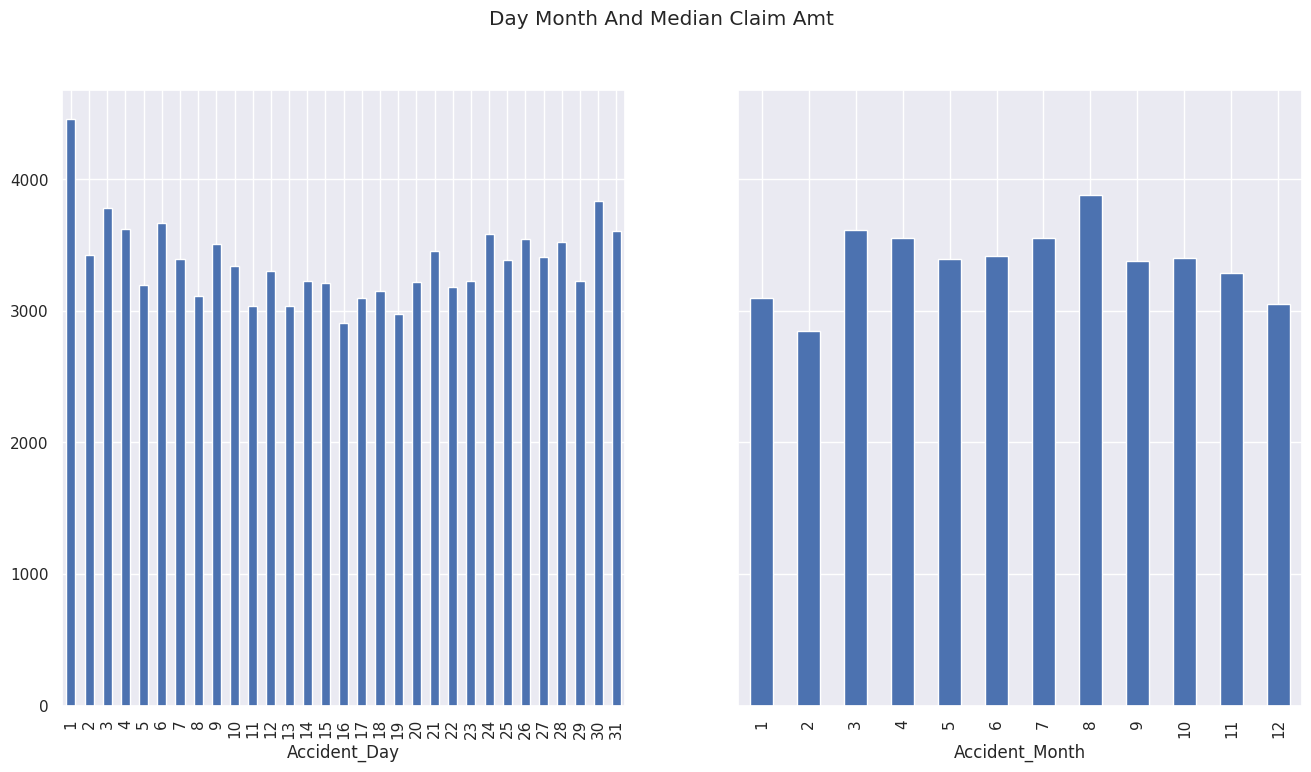

In [52]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
fig.suptitle('Day Month And Median Claim Amt')
plt.ylabel('Median Claim Amt')

train.groupby(train['Accident_Day'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[0])
train.groupby(train['Accident_Month'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[1])

plt.show()


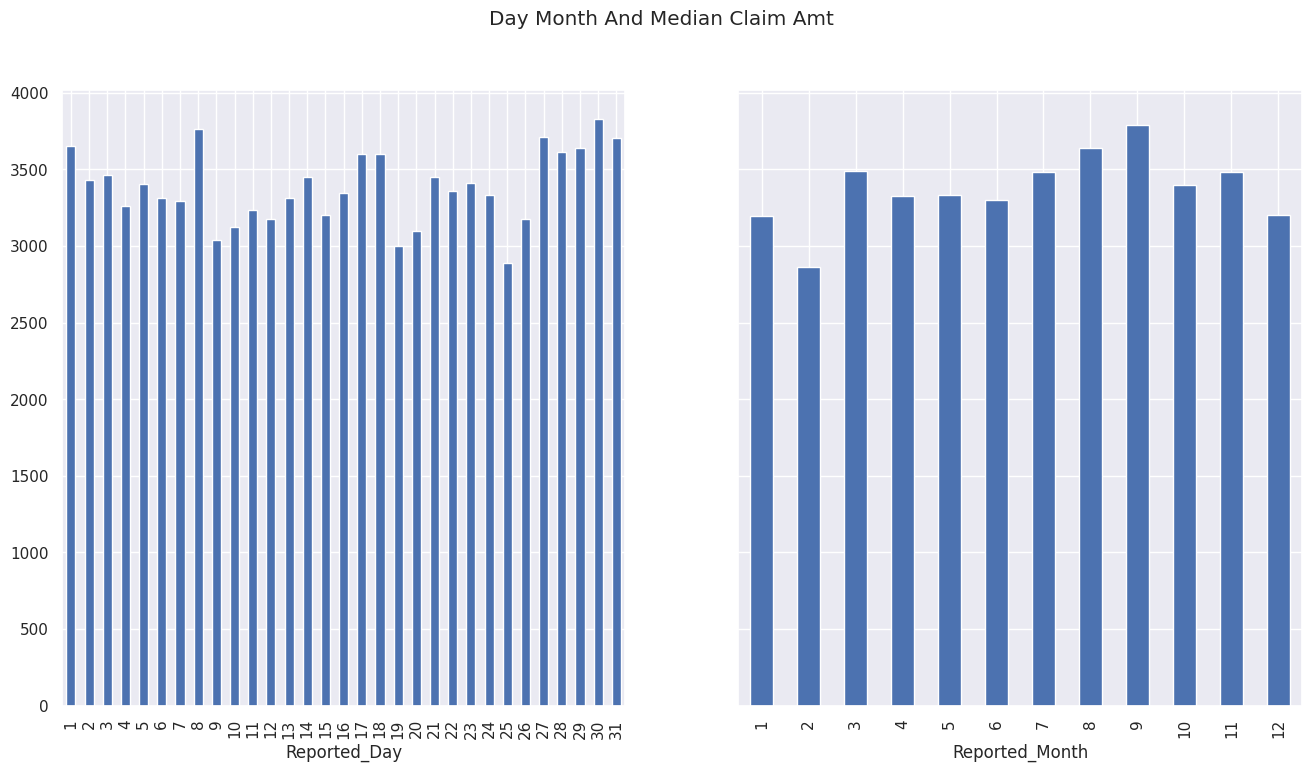

In [53]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
fig.suptitle('Day Month And Median Claim Amt')
plt.ylabel('Median Claim Amt')

train.groupby(train['Reported_Day'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[0])
train.groupby(train['Reported_Month'])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[1])

plt.show()



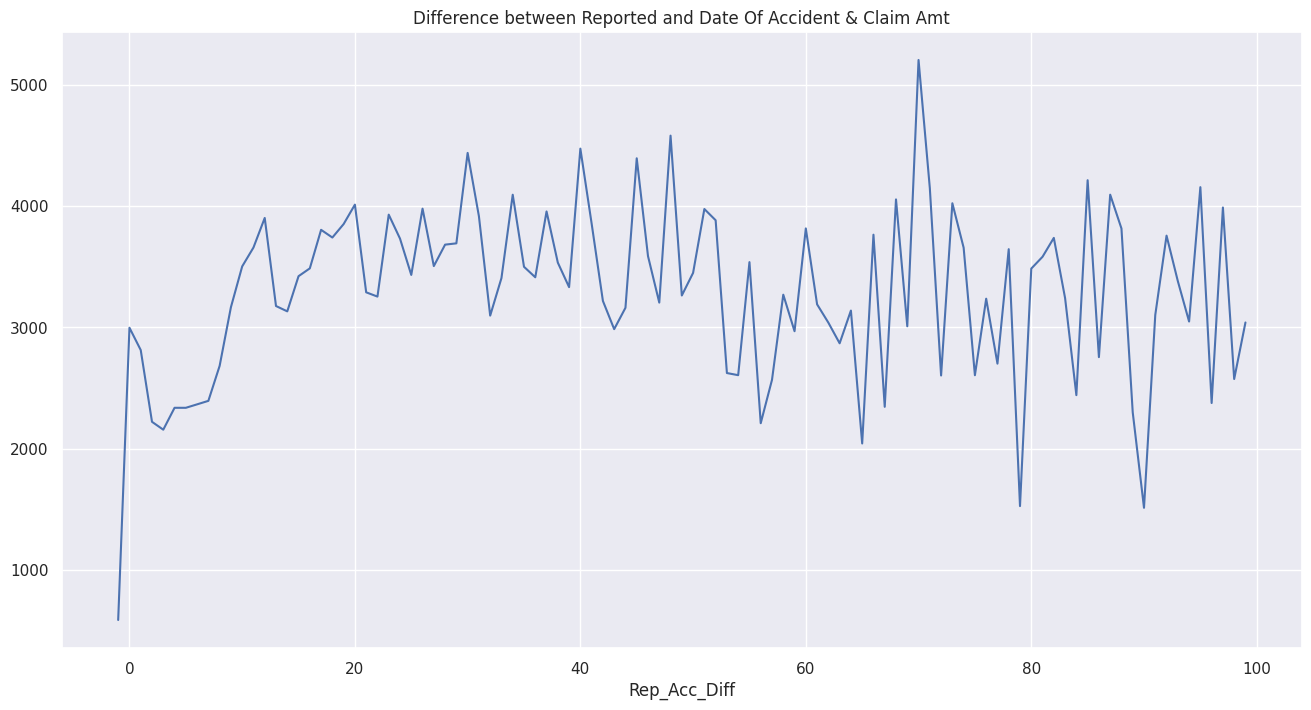

In [54]:
plt.figure(figsize=(16,8))
train.groupby(train['Rep_Acc_Diff'])['UltimateIncurredClaimCost'].median().plot()
plt.title('Difference between Reported and Date Of Accident & Claim Amt')
plt.show()

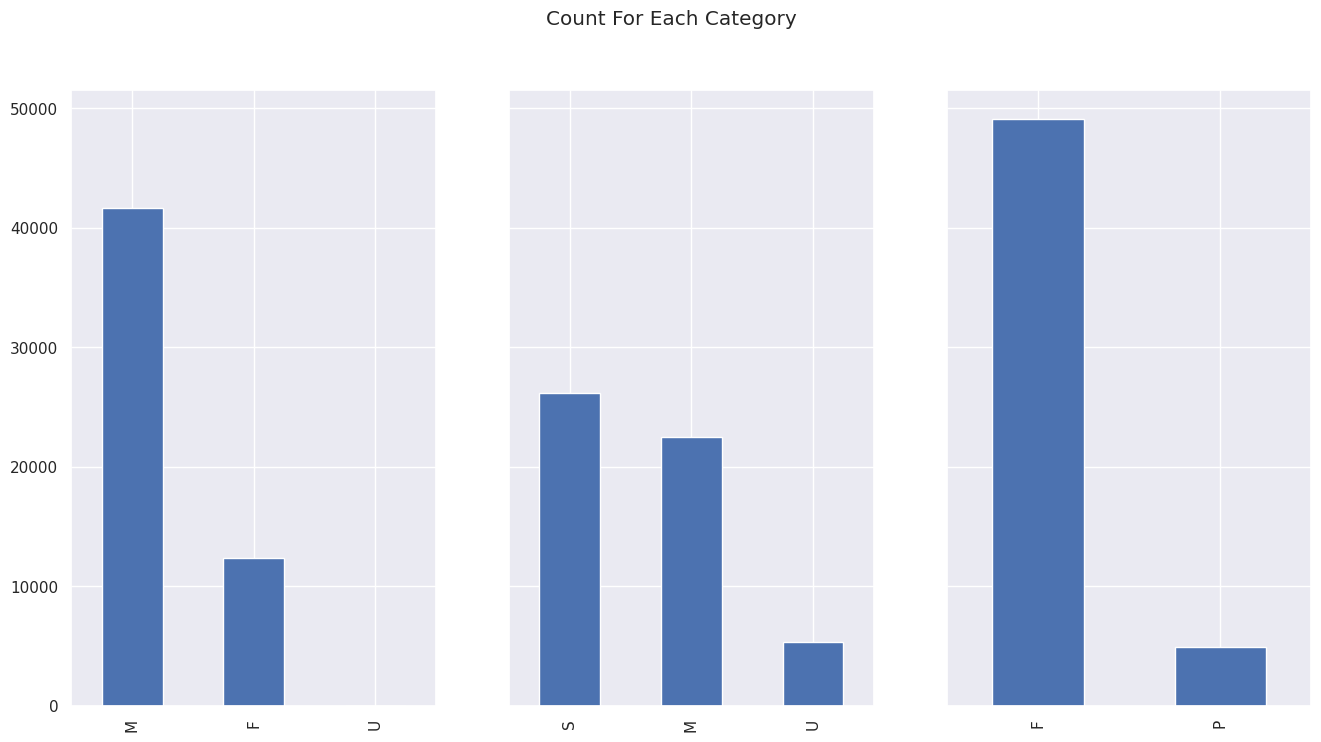

In [55]:


categoric=['Gender','MaritalStatus','PartTimeFullTime']
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,8))
fig.suptitle('Count For Each Category')

for i,col in enumerate(categoric):
    train[col].value_counts().plot(kind='bar',ax=ax[i])



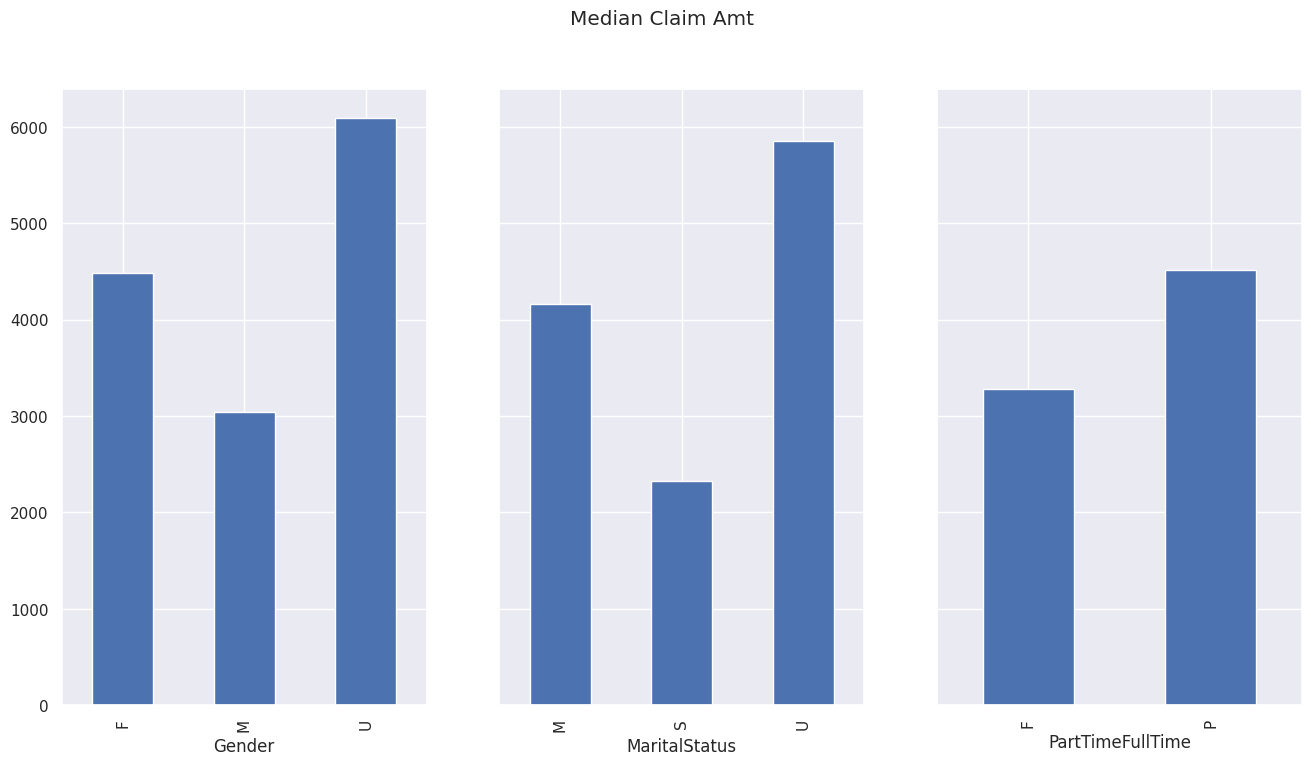

In [56]:


categoric=['Gender','MaritalStatus','PartTimeFullTime']
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,8))
fig.suptitle('Median Claim Amt')

for i,col in enumerate(categoric):
    train.groupby(train[col])['UltimateIncurredClaimCost'].median().plot(kind='bar',ax=ax[i])



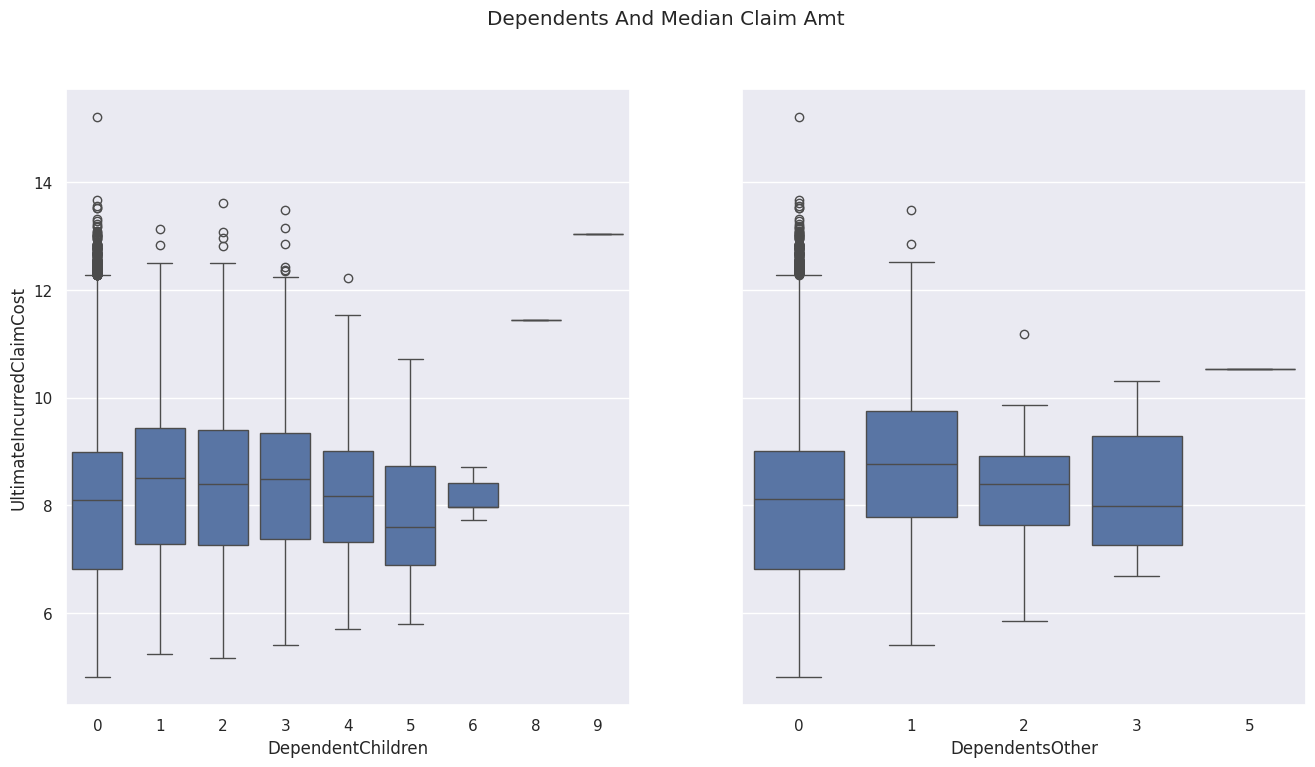

In [57]:
dep=['DependentChildren','DependentsOther']
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,8))
fig.suptitle('Dependents And Median Claim Amt')

for i,col in enumerate(dep):
    sns.boxplot(x=train[col],y=np.log(train['UltimateIncurredClaimCost']),ax=ax[i])

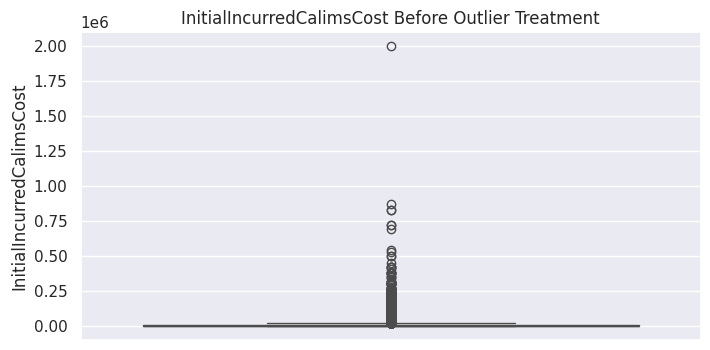

In [58]:


#Outlier Analysis of InitialIncurredCalimsCost

sns.boxplot(df_all['InitialIncurredCalimsCost'])
plt.title('InitialIncurredCalimsCost Before Outlier Treatment')
plt.show()



In [59]:


#Capping Outliers
df_all.loc[df_all['InitialIncurredCalimsCost']>=df_all['InitialIncurredCalimsCost'].quantile(.95),'InitialIncurredCalimsCost']=df_all['InitialIncurredCalimsCost'].quantile(.95)



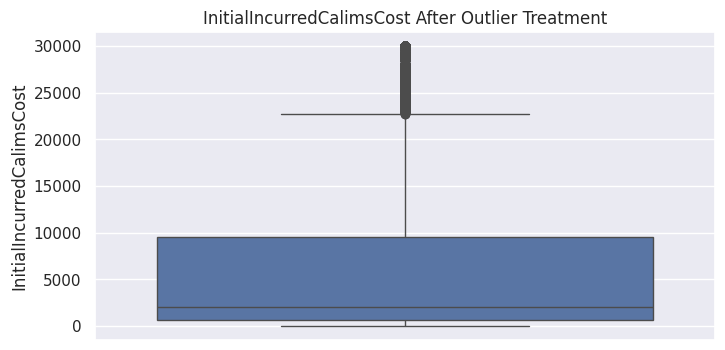

In [60]:


sns.boxplot(df_all['InitialIncurredCalimsCost'])
plt.title('InitialIncurredCalimsCost After Outlier Treatment')
plt.show()



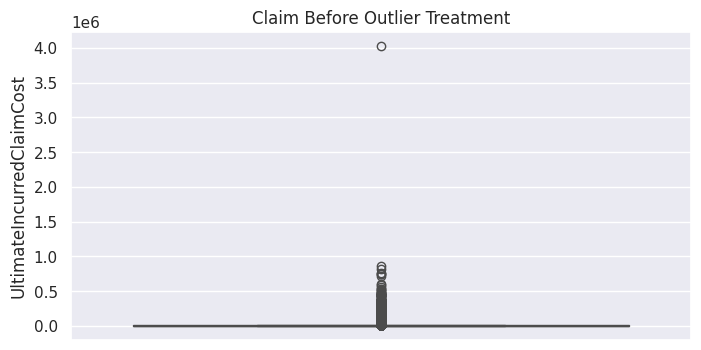

In [61]:


sns.boxplot(df_all['UltimateIncurredClaimCost'])
plt.title('Claim Before Outlier Treatment')
plt.show()



In [62]:


# Outlier Treatment

train.loc[train['UltimateIncurredClaimCost']>=train['UltimateIncurredClaimCost'].quantile(.95),'UltimateIncurredClaimCost']=train['UltimateIncurredClaimCost'].quantile(.95)



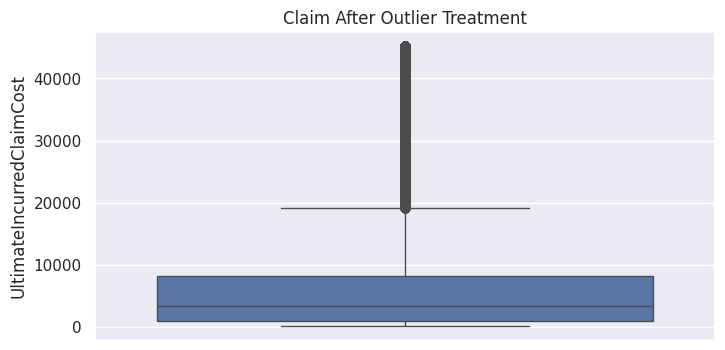

In [63]:
#After Outlier Treatment

sns.boxplot(train['UltimateIncurredClaimCost'])
plt.title('Claim After Outlier Treatment')
plt.show()

In [64]:


train=df_all[df_all.role=='train']
test=df_all[df_all.role=='test']



In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        54000 non-null  int64  
 1   DependentChildren          54000 non-null  int64  
 2   DependentsOther            54000 non-null  int64  
 3   WeeklyWages                54000 non-null  float64
 4   HoursWorkedPerWeek         54000 non-null  float64
 5   DaysWorkedPerWeek          54000 non-null  int64  
 6   InitialIncurredCalimsCost  54000 non-null  int64  
 7   UltimateIncurredClaimCost  54000 non-null  float64
 8   CD_foreign_bodi            54000 non-null  int64  
 9   CD_lacer                   54000 non-null  int64  
 10  CD_tissu_injuri            54000 non-null  int64  
 11  CD_strain                  54000 non-null  int64  
 12  CD_lower_back              54000 non-null  int64  
 13  CD_knee                    54000 non-null  int

In [65]:
train_id=train.ClaimNumber
test_id=test.ClaimNumber

train.drop(['ClaimNumber','DateTimeOfAccident', 'DateReported','ClaimDescription','role', 'word_count',
       'ClaimDescriptionClean','Accident_Time'],axis=1,inplace=True)

test.drop(['ClaimNumber','DateTimeOfAccident', 'DateReported','ClaimDescription','role', 'word_count',
       'ClaimDescriptionClean','Accident_Time'],axis=1,inplace=True)

In [66]:


train=pd.get_dummies(train)
test=pd.get_dummies(test)



In [67]:


train.drop(['Gender_U','MaritalStatus_U','PartTimeFullTime_P'],axis=1,inplace=True)
test.drop(['MaritalStatus_U','PartTimeFullTime_P'],axis=1,inplace=True)



In [68]:


####  Train test Split of train data
from sklearn.model_selection import  train_test_split



In [74]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 35999
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   ClaimNumber                90000 non-null  object             
 1   DateTimeOfAccident         90000 non-null  datetime64[ns, UTC]
 2   DateReported               90000 non-null  datetime64[ns, UTC]
 3   Age                        90000 non-null  int64              
 4   Gender                     90000 non-null  object             
 5   MaritalStatus              90000 non-null  object             
 6   DependentChildren          90000 non-null  int64              
 7   DependentsOther            90000 non-null  int64              
 8   WeeklyWages                90000 non-null  float64            
 9   PartTimeFullTime           90000 non-null  object             
 10  HoursWorkedPerWeek         90000 non-null  float64            
 11  Da

In [69]:


X=train.drop(['UltimateIncurredClaimCost'],axis=1)
Y=train['UltimateIncurredClaimCost']



In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        54000 non-null  int64  
 1   DependentChildren          54000 non-null  int64  
 2   DependentsOther            54000 non-null  int64  
 3   WeeklyWages                54000 non-null  float64
 4   HoursWorkedPerWeek         54000 non-null  float64
 5   DaysWorkedPerWeek          54000 non-null  int64  
 6   InitialIncurredCalimsCost  54000 non-null  int64  
 7   CD_foreign_bodi            54000 non-null  int64  
 8   CD_lacer                   54000 non-null  int64  
 9   CD_tissu_injuri            54000 non-null  int64  
 10  CD_strain                  54000 non-null  int64  
 11  CD_lower_back              54000 non-null  int64  
 12  CD_knee                    54000 non-null  int64  
 13  CD_wrist                   54000 non-null  int

In [70]:


X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.7)



In [72]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37800 entries, 38775 to 15918
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        37800 non-null  int64  
 1   DependentChildren          37800 non-null  int64  
 2   DependentsOther            37800 non-null  int64  
 3   WeeklyWages                37800 non-null  float64
 4   HoursWorkedPerWeek         37800 non-null  float64
 5   DaysWorkedPerWeek          37800 non-null  int64  
 6   InitialIncurredCalimsCost  37800 non-null  int64  
 7   CD_foreign_bodi            37800 non-null  int64  
 8   CD_lacer                   37800 non-null  int64  
 9   CD_tissu_injuri            37800 non-null  int64  
 10  CD_strain                  37800 non-null  int64  
 11  CD_lower_back              37800 non-null  int64  
 12  CD_knee                    37800 non-null  int64  
 13  CD_wrist                   37800 non-null 

In [73]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16200 entries, 40181 to 38265
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        16200 non-null  int64  
 1   DependentChildren          16200 non-null  int64  
 2   DependentsOther            16200 non-null  int64  
 3   WeeklyWages                16200 non-null  float64
 4   HoursWorkedPerWeek         16200 non-null  float64
 5   DaysWorkedPerWeek          16200 non-null  int64  
 6   InitialIncurredCalimsCost  16200 non-null  int64  
 7   CD_foreign_bodi            16200 non-null  int64  
 8   CD_lacer                   16200 non-null  int64  
 9   CD_tissu_injuri            16200 non-null  int64  
 10  CD_strain                  16200 non-null  int64  
 11  CD_lower_back              16200 non-null  int64  
 12  CD_knee                    16200 non-null  int64  
 13  CD_wrist                   16200 non-null 

In [78]:
import xgboost

In [79]:


#Training on default params
model = xgboost.XGBRegressor() 
model.fit(X_train,y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [80]:
model.predict(X_test)

array([ 2456.9678,  1288.2854, 53806.527 , ..., 13635.173 ,  2446.416 ,
        1588.2471], dtype=float32)

In [81]:


from sklearn.metrics import mean_absolute_error



In [82]:


mean_absolute_error(y_test,model.predict(X_test))



8678.269988022355

In [83]:


parameters={'colsample_bytree':[0.4],
                 'gamma':[0],                 
                 'learning_rate':[0.07,0.09,0.1],
                 'max_depth':[2,3,4],
                 'n_estimators':[1000,2000,3000],                                                                   
                 'reg_alpha':[0.7,0.75,0.8],
                 'reg_lambda':[0.45,0.8,1],
                 'subsample':[0.6],
                 }



In [84]:
from sklearn.model_selection import RandomizedSearchCV


In [86]:


reg_clf=RandomizedSearchCV(estimator=model,param_distributions=parameters,cv=3,n_jobs=-1,scoring='neg_mean_absolute_error',verbose=100)

In [88]:


mean_absolute_error(y_test,reg_clf.estimator.predict(X_test))



8678.269988022355